# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [4]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [6]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['training_loss','validation_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['training_categorical_accuracy','validation_categorical_accuracy'])

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [7]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 36 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)                   
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32) 
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image  
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## MODEL TYPE-1 (CONV-3D)
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [36]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, MaxPooling2D, TimeDistributed, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16

### Model 1 (3 Conv3D layers) with Generator 1 (Image per sequence = 18, Image Size=120x120, Batch Size=36)

In [8]:
#write your model here

model = Sequential()
model.add(Conv3D(16, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,120,120,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 18, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 120, 120, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 18, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 9, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 60, 60, 32)     128       
_________________________________________________________________
activation_1 (Activation)    (None, 9, 60, 60, 32)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 36
Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 12.3779 - categorical_accuracy: 0.2881Source path =  /home/datasets/Project_data/val ; batch size = 36

Epoch 00001: saving model to model_init_2021-08-0210_28_45.083856/model-00001-12.37785-0.28808-14.68375-0.16000.h5
19/19 [==============================] - 94s 5s/step - loss: 12.3779 - categorical_accuracy: 0.2881 - val_loss: 14.6838 - val_categorical_accuracy: 0.1600
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 1.6957 - categorical_accuracy: 0.4721
Epoch 00002: saving model to model_init_2021-08-0210_28_45.083856/model-00002-1.69575-0.47210-2.99501-0.17000.h5
19/19 [==============================] - 97s 5s/step - loss: 1.6957 - categorical_accuracy: 0.4721 - val_loss: 2.9950 - val_categorical_accuracy: 0.1700
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 1.0389 - categorical_accuracy: 0.5822
Epoch 00003: 

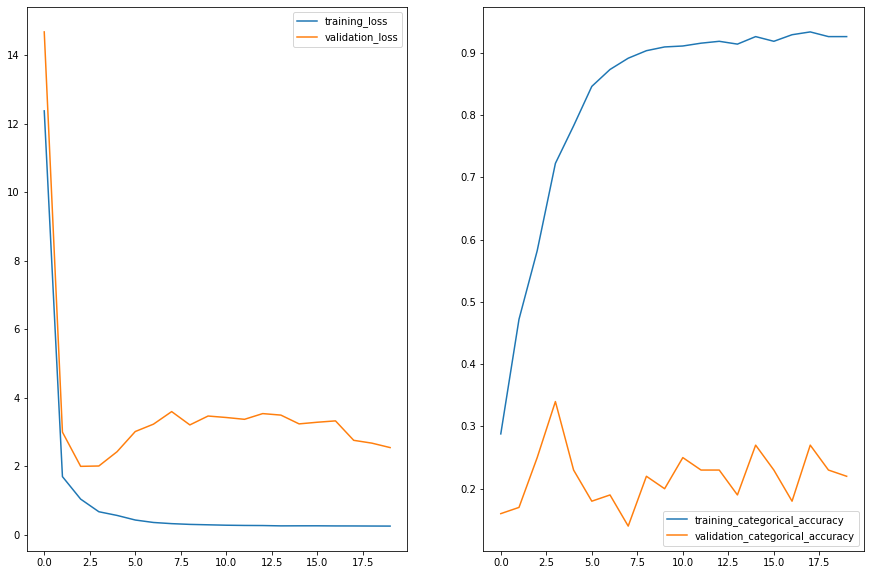

In [14]:
plot(model.history)

#### Model 1 is overfitting with 1.9 million parameters. Need to add more layers with dropouts to extract the features better and to reduce the overfitting tendency.

### Model 2 (4 Conv3D layers with Dropouts) with Generator 1 (Image per sequence = 18, Image Size=120x120, Batch Size=36)

In [15]:
model2 = Sequential()
model2.add(Conv3D(16, (3,3,3), padding='same', input_shape=(18,120,120,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(32, (3,3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, (3,3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(128, (3,3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Dropout(0.2))
    
model2.add(Flatten())
model2.add(Dense(128,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Dense(128,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(5,activation='softmax'))

In [16]:
optimiser = optimizers.Adam()
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 18, 120, 120, 16)  1312      
_________________________________________________________________
activation_3 (Activation)    (None, 18, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 18, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 9, 60, 60, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 9, 60, 60, 32)     13856     
_________________________________________________________________
activation_4 (Activation)    (None, 9, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 60, 60, 32)    

In [17]:
model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 1.6635 - categorical_accuracy: 0.4148
Epoch 00001: saving model to model_init_2021-08-0210_28_45.083856/model-00001-1.66350-0.41478-1.61412-0.21000.h5
19/19 [==============================] - 91s 5s/step - loss: 1.6635 - categorical_accuracy: 0.4148 - val_loss: 1.6141 - val_categorical_accuracy: 0.2100
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 1.1126 - categorical_accuracy: 0.5566
Epoch 00002: saving model to model_init_2021-08-0210_28_45.083856/model-00002-1.11260-0.55656-1.92858-0.25000.h5
19/19 [==============================] - 91s 5s/step - loss: 1.1126 - categorical_accuracy: 0.5566 - val_loss: 1.9286 - val_categorical_accuracy: 0.2500
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.7529 - categorical_accuracy: 0.7104
Epoch 00003: saving model to model_init_2021-08-0210_28_45.083856/model-00003-0.75292-0.71041-3.69173-0.22000.h5

Epoch 00003: ReduceLROnPlateau reduc

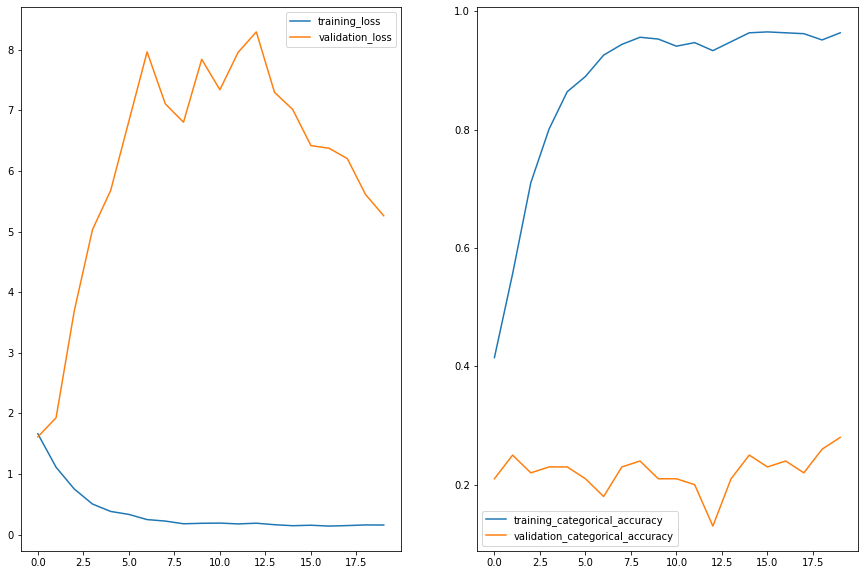

In [18]:
plot(model2.history)

#### Model 2 is overfitting badly let's tweak the parameters in Generator function.

In [19]:
# Batch Size is now of size 30 and we are feeding all the images in the sequence.
batch_size = 30

In [20]:
def generator2(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,30,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)                   
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32) 
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image  
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [21]:
train_generator2 = generator2(train_path, train_doc, batch_size)
val_generator2 = generator2(val_path, val_doc, batch_size)

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Model 3 (same as Model 2 with 4 Conv3D layer with dropouts) with Generator 2 (Image per sequence = 30, Image Size=120x120, Batch Size=30)

In [23]:
model3 = Sequential()
model3.add(Conv3D(16, (3,3,3), padding='same', input_shape=(30,120,120,3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(32, (3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(64, (3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(128, (3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.2))
    
model3.add(Flatten())
model3.add(Dense(128,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

model3.add(Dense(128,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))
model3.add(Dense(5,activation='softmax'))

In [24]:
optimiser = optimizers.Adam()
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_7 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_8 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 60, 60, 32)   

In [25]:
model3.fit(train_generator2, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator2, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6505 - categorical_accuracy: 0.4268Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-08-0210_28_45.083856/model-00001-1.65053-0.42685-2.19759-0.14000.h5
23/23 [==============================] - 144s 6s/step - loss: 1.6505 - categorical_accuracy: 0.4268 - val_loss: 2.1976 - val_categorical_accuracy: 0.1400
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.0965 - categorical_accuracy: 0.5581
Epoch 00002: saving model to model_init_2021-08-0210_28_45.083856/model-00002-1.09651-0.55807-2.21673-0.25000.h5
23/23 [==============================] - 148s 6s/step - loss: 1.0965 - categorical_accuracy: 0.5581 - val_loss: 2.2167 - val_categorical_accuracy: 0.2500
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.8788 - categorical_accuracy: 0.6682
Epoch 00003: sav

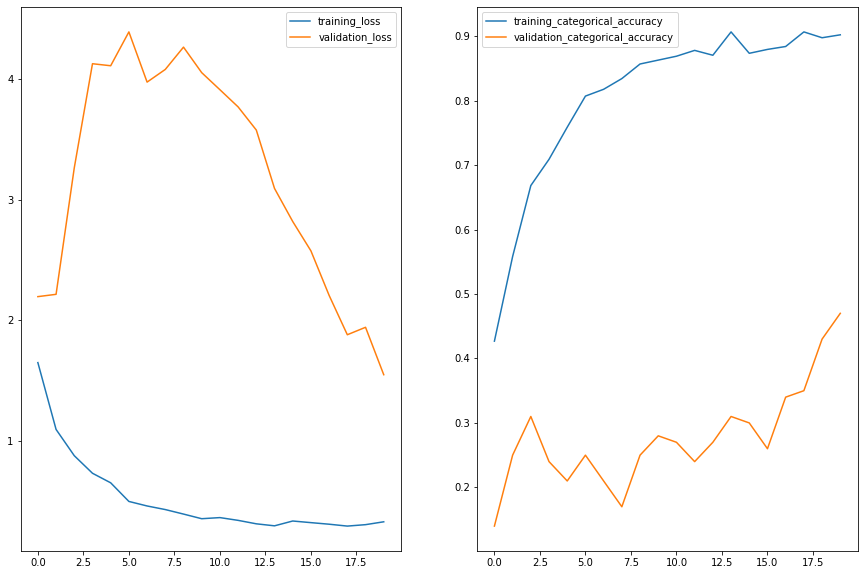

In [26]:
plot(model3.history)

#### Model-3 is still overfitting so we need to tweak the generator function even more.

In [13]:
# Changing the batch size to 40 and using 20 images with mean normalisation 
batch_size = 40

In [14]:
def generator3(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,3,4,6,8,10,12,14,15,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)                   
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32) 
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104 #normalise and feed in the image  
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,20,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [15]:
train_generator3 = generator3(train_path, train_doc, batch_size)
val_generator3 = generator3(val_path, val_doc, batch_size)

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Model 4 (same as Model 3 with 4 Conv3D layer with dropouts) with Generator 3 (Image per sequence = 20, Image Size=120x120, Batch Size=40 with mean normalisation)

In [31]:
model4 = Sequential()
model4.add(Conv3D(16, (3,3,3), padding='same', input_shape=(20,120,120,3)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(32, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(64, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(128, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model4.add(Dropout(0.2))
    
model4.add(Flatten())
model4.add(Dense(128,activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))

model4.add(Dense(128,activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.3))
model4.add(Dense(5,activation='softmax'))

In [ ]:
optimiser = optimizers.Adam()
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_11 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_12 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 10, 60, 60, 32)   

In [ ]:
model4.fit(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.6208 - categorical_accuracy: 0.4178Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-08-0210_28_45.083856/model-00001-1.62076-0.41780-44.07473-0.24000.h5
17/17 [==============================] - 108s 6s/step - loss: 1.6208 - categorical_accuracy: 0.4178 - val_loss: 44.0747 - val_categorical_accuracy: 0.2400
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.9336 - categorical_accuracy: 0.6365
Epoch 00002: saving model to model_init_2021-08-0210_28_45.083856/model-00002-0.93356-0.63650-22.27465-0.27000.h5
17/17 [==============================] - 108s 6s/step - loss: 0.9336 - categorical_accuracy: 0.6365 - val_loss: 22.2746 - val_categorical_accuracy: 0.2700
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.6673 - categorical_accuracy: 0.7572
Epoch 00003:

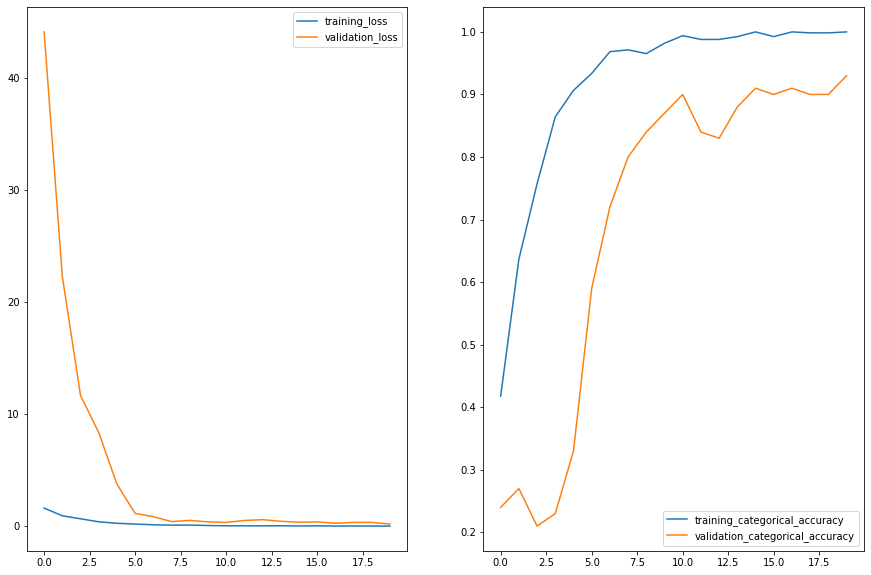

In [ ]:
plot(model4.history)

#### Model 4 is performing better than the previous models but it is still overfiting to a certain extent on training set so let's increase the dropout layers to reduce that.

### Model 5 (4 Conv3D layer with more Dropouts layer) with Generator 3 (Image per sequence = 20, Image Size=120x120, Batch Size=40 with mean normalisation)

In [ ]:
model5 = Sequential()
model5.add(Conv3D(16, (3,3,3), padding='same', input_shape=(20,120,120,3)))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model5.add(Conv3D(32, (3,3,3), padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model5.add(Conv3D(64, (3,3,3), padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Dropout(0.2))

model5.add(Conv3D(128, (3,3,3), padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Dropout(0.2))
    
model5.add(Flatten())
model5.add(Dense(128,activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.4))

model5.add(Dense(128,activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.4))
model5.add(Dense(5,activation='softmax'))

In [ ]:
optimiser = optimizers.Adam()
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_15 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_16 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 10, 60, 60, 32)   

In [ ]:
model5.fit(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.7389 - categorical_accuracy: 0.4057
Epoch 00001: saving model to model_init_2021-08-0210_28_45.083856/model-00001-1.73886-0.40573-53.07361-0.19000.h5
17/17 [==============================] - 108s 6s/step - loss: 1.7389 - categorical_accuracy: 0.4057 - val_loss: 53.0736 - val_categorical_accuracy: 0.1900
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.1179 - categorical_accuracy: 0.5822
Epoch 00002: saving model to model_init_2021-08-0210_28_45.083856/model-00002-1.11794-0.58220-36.87535-0.23000.h5
17/17 [==============================] - 112s 7s/step - loss: 1.1179 - categorical_accuracy: 0.5822 - val_loss: 36.8754 - val_categorical_accuracy: 0.2300
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.8144 - categorical_accuracy: 0.6833
Epoch 00003: saving model to model_init_2021-08-0210_28_45.083856/model-00003-0.81437-0.68326-15.59547-0.25000.h5
17/17 [=======================

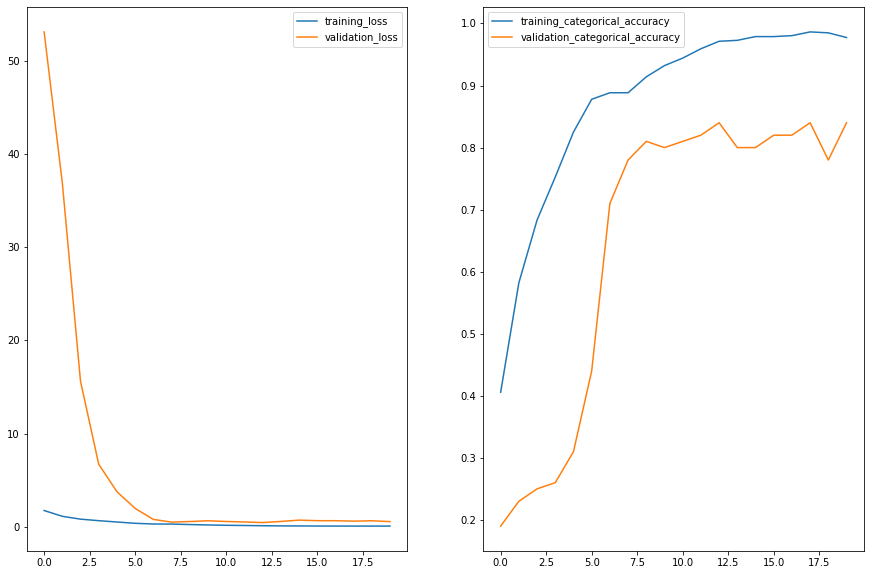

In [52]:
plot(model5.history)

Model-5 now has a reduced validation accuracy, so now we try to reduce the number of trainable parameters and aim to achieve a higher validation accuracy.

#### Reducing Image size to 90x90 reduce the number of parameters

In [45]:
def generator4(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,3,4,6,8,10,12,14,15,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,90,90,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)                   
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(90,90)).astype(np.float32) 
                    else:
                        image = resize(image,(90,90)).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104 #normalise and feed in the image  
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,20,90,90,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(90,90)).astype(np.float32)
                    else:
                        image = resize(image,(90,90)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [46]:
train_generator4 = generator4(train_path, train_doc, batch_size)
val_generator4 = generator4(val_path, val_doc, batch_size)

In [47]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### Model 6 (Same as model 4) with Generator 4 (Image per sequence = 20, Image Size=90x90, Batch Size=40 with mean normalisation)

In [48]:
model6 = Sequential()
model6.add(Conv3D(16, (3,3,3), padding='same', input_shape=(20,90,90,3)))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model6.add(Conv3D(32, (3,3,3), padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model6.add(Conv3D(64, (3,3,3), padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model6.add(Conv3D(128, (3,3,3), padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Dropout(0.2))
    
model6.add(Flatten())
model6.add(Dense(128,activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.3))

model6.add(Dense(128,activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.3))
model6.add(Dense(5,activation='softmax'))

In [49]:
optimiser = optimizers.Adam()
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_23 (Conv3D)           (None, 20, 90, 90, 16)    1312      
_________________________________________________________________
activation_23 (Activation)   (None, 20, 90, 90, 16)    0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 20, 90, 90, 16)    64        
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 10, 45, 45, 16)    0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 10, 45, 45, 32)    13856     
_________________________________________________________________
activation_24 (Activation)   (None, 10, 45, 45, 32)    0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 10, 45, 45, 32)   

In [50]:
model6.fit(train_generator4, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator4, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.6508 - categorical_accuracy: 0.4314Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-08-0210_28_45.083856/model-00001-1.65082-0.43137-48.77182-0.23000.h5
17/17 [==============================] - 102s 6s/step - loss: 1.6508 - categorical_accuracy: 0.4314 - val_loss: 48.7718 - val_categorical_accuracy: 0.2300
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.0655 - categorical_accuracy: 0.5928
Epoch 00002: saving model to model_init_2021-08-0210_28_45.083856/model-00002-1.06552-0.59276-30.57574-0.22000.h5
17/17 [==============================] - 102s 6s/step - loss: 1.0655 - categorical_accuracy: 0.5928 - val_loss: 30.5757 - val_categorical_accuracy: 0.2200
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.7031 - categorical_accuracy: 0.7315
Epoch 00003:

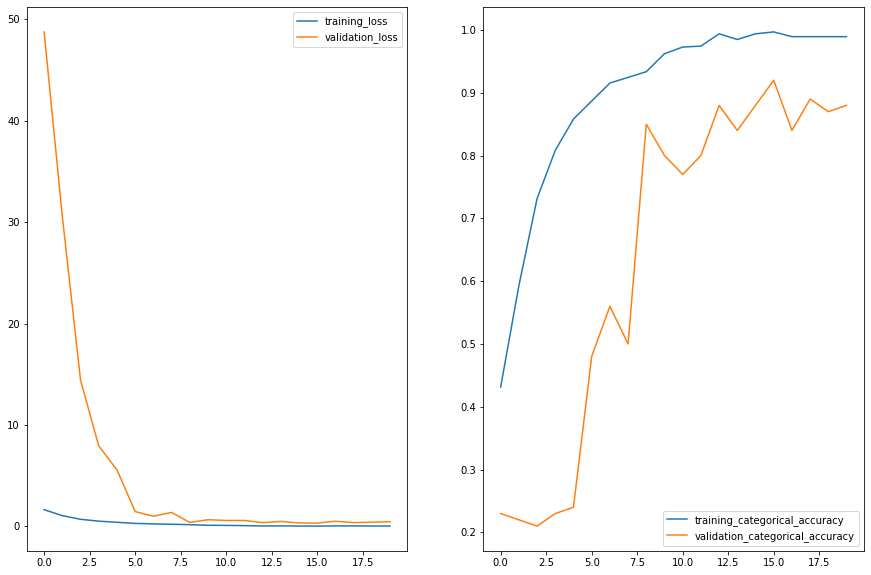

In [51]:
plot(model6.history)

The Model-6 has 30% less number of paramters than model-5 and we are achieving a higher validation accuracy.

Final model selection: Epoch-16
- Training accuracy: categorical_accuracy - 0.9970
- Validation accuracy: val_categorical_accuracy: 0.9200

## MODEL TYPE-2 (CNN+RNN)

### Model 7 (4 Conv2D layers with GRU layer and Dropouts) with Generator 3 (Image per sequence = 20, Image Size=120x120, Batch Size=40 with mean normalisation)

In [20]:
model7 = Sequential()
model7.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(20,120,120,3)))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Flatten()))

model7.add(GRU(128))
model7.add(Dropout(0.25))
model7.add(Dense(128,activation='relu'))
model7.add(Dropout(0.25))
model7.add(Dense(5, activation='softmax'))

In [21]:
optimiser = optimizers.Adam()
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 64)    1

In [24]:
model7.fit(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.4106 - categorical_accuracy: 0.4329Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-08-0214_38_12.163362/model-00001-1.41057-0.43288-1.72852-0.24000.h5
17/17 [==============================] - 105s 6s/step - loss: 1.4106 - categorical_accuracy: 0.4329 - val_loss: 1.7285 - val_categorical_accuracy: 0.2400
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.9401 - categorical_accuracy: 0.6621
Epoch 00002: saving model to model_init_2021-08-0214_38_12.163362/model-00002-0.94007-0.66214-2.32064-0.21000.h5
17/17 [==============================] - 109s 6s/step - loss: 0.9401 - categorical_accuracy: 0.6621 - val_loss: 2.3206 - val_categorical_accuracy: 0.2100
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.7569 - categorical_accuracy: 0.7315
Epoch 00003: sav

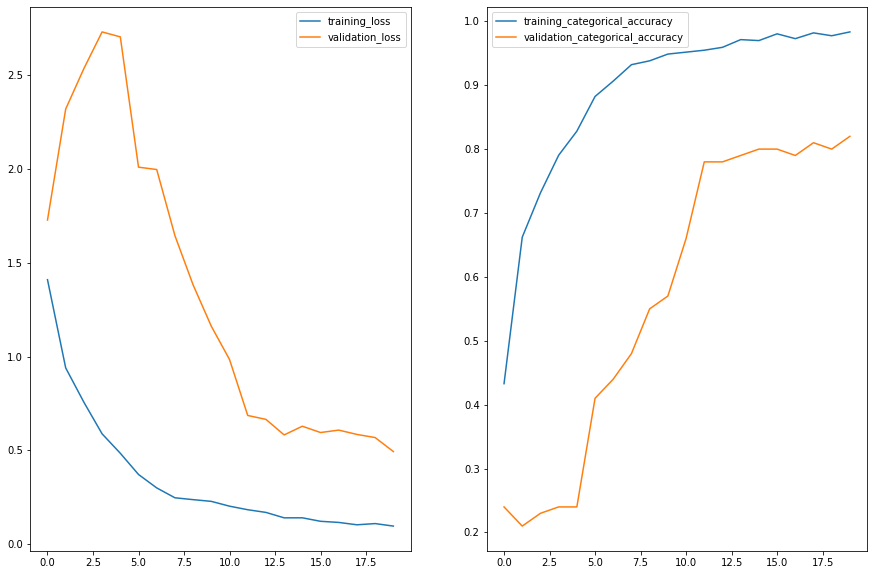

In [25]:
plot(model7.history)

Moedl-7 has an overfitting tendency and now we try to increase the dropout ratio to counter the same.

In [31]:
model8 = Sequential()
model8.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(20,120,120,3)))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model8.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model8.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model8.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model8.add(TimeDistributed(Flatten()))

model8.add(GRU(128))
model8.add(Dropout(0.75))
model8.add(Dense(128,activation='relu'))
model8.add(Dropout(0.50))
model8.add(Dense(5, activation='softmax'))

In [33]:
optimiser = optimizers.Adam()
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_22 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_23 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_24 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_27 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 20, 30, 30, 64)   

In [34]:
model8.fit(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 2.3497 - categorical_accuracy: 0.2142
Epoch 00001: saving model to model_init_2021-08-0214_38_12.163362/model-00001-2.34972-0.21418-1.72899-0.27000.h5
17/17 [==============================] - 98s 6s/step - loss: 2.3497 - categorical_accuracy: 0.2142 - val_loss: 1.7290 - val_categorical_accuracy: 0.2700
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.9222 - categorical_accuracy: 0.2866
Epoch 00002: saving model to model_init_2021-08-0214_38_12.163362/model-00002-1.92217-0.28658-1.70639-0.23000.h5
17/17 [==============================] - 101s 6s/step - loss: 1.9222 - categorical_accuracy: 0.2866 - val_loss: 1.7064 - val_categorical_accuracy: 0.2300
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.8251 - categorical_accuracy: 0.3047
Epoch 00003: saving model to model_init_2021-08-0214_38_12.163362/model-00003-1.82510-0.30468-1.72968-0.22000.h5
17/17 [=============================

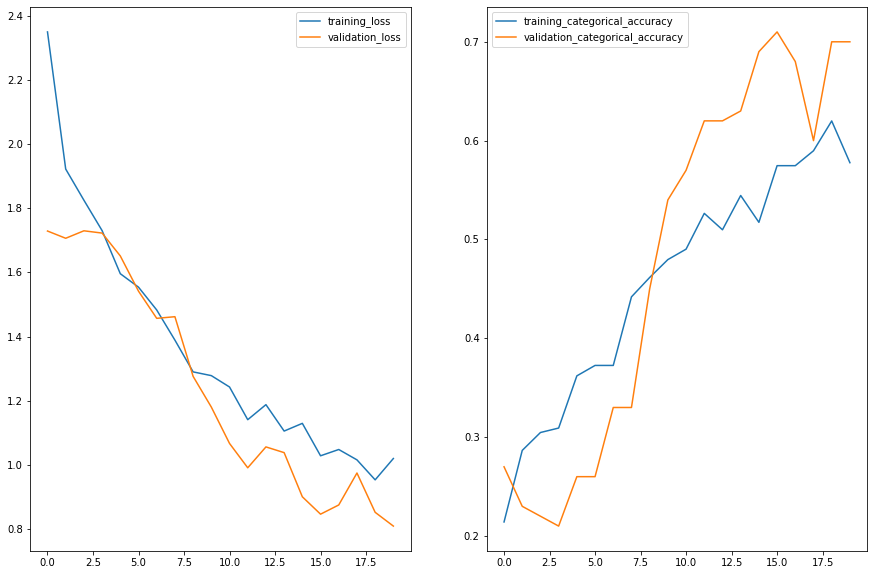

In [35]:
plot(model8.history)

Model-8 has now underfitting tendency due to higher dropout ratio. So, one can experiment with the optimum dropout ratio by decreasing it.

### Model 9 (Transfer Learning with VGGnet) with Generator 3 (Image per sequence = 20, Image Size=120x120, Batch Size=40 with mean normalisation)

In [37]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model9 = Sequential()
model9.add(TimeDistributed(conv_model, input_shape=(20,120,120,3)))
model9.add(GRU(32, return_sequences=True))
model9.add(GRU(16))
model9.add(Dropout(0.3))
model9.add(Dense(8, activation='relu'))
model9.add(Dense(5, activation='softmax'))

In [38]:
optimiser = optimizers.Adam()
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_35 (TimeDis (None, 20, 64)            15009664  
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 32)            9408      
_________________________________________________________________
gru_3 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 45        
Total params: 15,021,653
Trainable params: 306,965
Non-trainable params: 14,714,688
____________________________________

In [39]:
train_generator3 = generator3(train_path, train_doc, batch_size)
val_generator3 = generator3(val_path, val_doc, batch_size)

In [40]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [43]:
model9.fit_generator(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.5784 - categorical_accuracy: 0.2308Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-08-0214_38_12.163362/model-00001-1.57840-0.23077-1.52486-0.29000.h5
17/17 [==============================] - 101s 6s/step - loss: 1.5784 - categorical_accuracy: 0.2308 - val_loss: 1.5249 - val_categorical_accuracy: 0.2900
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.4854 - categorical_accuracy: 0.3213
Epoch 00002: saving model to model_init_2021-08-0214_38_12.163362/model-00002-1.48536-0.32127-1.41265-0.34000.h5
17/17 [==============================] - 100s 6s/step - loss: 1.4854 - categorical_accuracy: 0.3213 - val_loss: 1.4126 - val_categorical_accuracy: 0.3400
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.3908 - categorical_accuracy: 0.3409
Epoch 00003: saving model to model_init_2021-08-0214_38_12.163362/model-00003-1.390

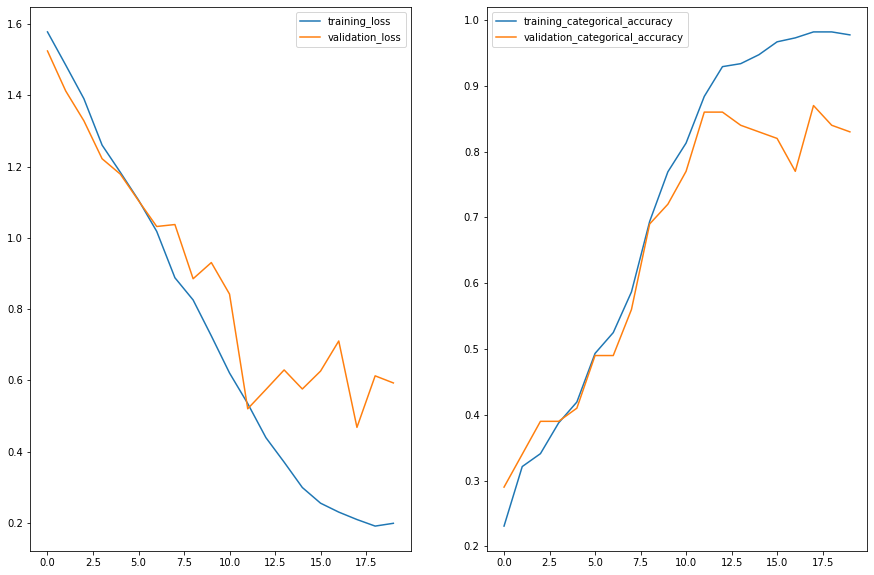

In [44]:
plot(model9.history)

We can perform early stopping to prevent overfitting or add more dropout layers with higher dropout ratio.

### CONCLUSION: After performing 9 experiments, the final model is model-6 as it meets the objective with the lowest number of total parameters and the highest validation accuracy.